In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
file_path = '/content/drive/My Drive/Colab Notebooks/dl-albanian/AlbAna-simplified.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=0)

In [3]:
#Create lists of Annotations and Comments
y = df['Annotation']
docs = df['Comment']

In [4]:
!pip install nlu==5.1.2
!pip install pyspark==3.4.1
!pip install spark-nlp==5.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=0588d87774ada00584e5042377d5af5a2fca2956e06b6699c36d09fbb33bd9e5
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [5]:
# Remove stop words

import pyspark
import sparknlp
from sparknlp.annotator import DocumentAssembler, Tokenizer, StopWordsCleaner
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Pipeline
spark = sparknlp.start()

# Create a Spark DataFrame containing text data
df = spark.createDataFrame([(text,) for text in docs], ["text"])

documentAssembler = DocumentAssembler() \
.setInputCol("text") \
.setOutputCol("document")

tokenizer = Tokenizer() \
.setInputCols(["document"]) \
.setOutputCol("token")

stop_words = StopWordsCleaner.pretrained("stopwords_iso","sq") \
.setInputCols(["token"]) \
.setOutputCol("cleanTokens")

pipeline = Pipeline(stages=[documentAssembler, tokenizer, stop_words])


# Define  pipeline
pipeline = Pipeline(stages=[documentAssembler, tokenizer, stop_words])

# Fitting the pipeline on Spark DataFrame to transform the text data
results = pipeline.fit(df).transform(df)
results.show(truncate=False)

stopwords_iso download started this may take some time.
Approximate size to download 1.9 KB
[OK!]
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

In [7]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=1000)

In [8]:
# Tokenization
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_inputs = tokenizer(x_train.tolist(), padding=True, truncation=True, return_tensors="pt")
test_inputs = tokenizer(x_test.tolist(), padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [10]:
# Model loading
num_labels = len(y.unique())
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=num_labels)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Fine-tuning parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [12]:
# Convert labels to tensor
train_labels = torch.tensor(y_train.tolist())
test_labels = torch.tensor(y_test.tolist())

In [13]:
# Create DataLoader for training and testing
train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, train_labels)
test_dataset = TensorDataset(test_inputs.input_ids, test_inputs.attention_mask, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [14]:
# Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(3):  # can adjust the number of epochs here
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader)}")

# Save the fine-tuned model
model.save_pretrained("/content/drive/My Drive/Colab Notebooks/dl-albanian/xlm-model")

Epoch 1, Average Loss: 0.871085719574005
Epoch 2, Average Loss: 0.6662910959584282
Epoch 3, Average Loss: 0.5785112358550442


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Accuracy: 0.7288240769469438
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1837
           1       0.78      0.67      0.72       507
           2       0.59      0.72      0.65       879

    accuracy                           0.73      3223
   macro avg       0.72      0.71      0.71      3223
weighted avg       0.74      0.73      0.73      3223

Confusion matrix, without normalization


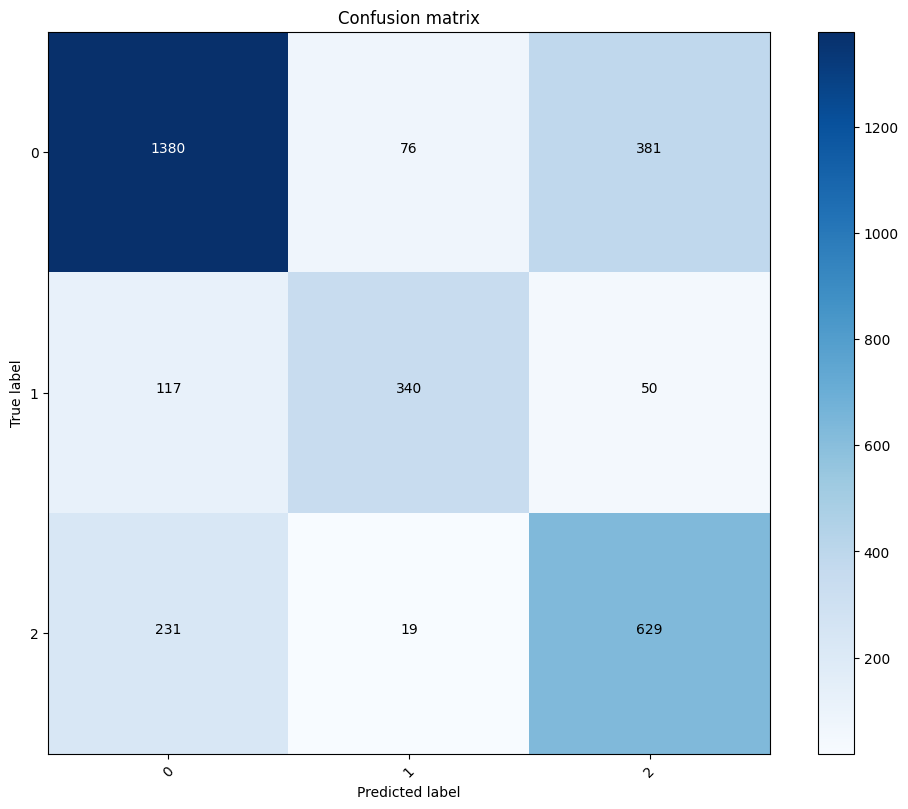

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test loader
for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Predictions
    preds = logits.argmax(dim=1)

    # Append predictions and true labels to lists
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# accuracy
accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)

# other metrics
print(classification_report(all_labels, all_preds))

# confusion matrix
cnf_matrix = confusion_matrix(all_labels, all_preds)
classes = ['0', '1', '2']
plot_confusion_matrix(cnf_matrix, classes=classes)
